In [1]:
import torch
from gmm import GMM
from mlp import ImprovedFourierNet, init_bias_uniform_zeros, kaiming_uniform_zeros_
from stochastic_interpolant import StochasticInterpolant
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm import tqdm

/root/tmp/toy/stochastic_interpolant.py:145: SyntaxWarning: invalid escape sequence '\s'
  dXt = [drift_fn(t, Xt) + diffusion_fn(t) * score_fn(t, Xt)]dt + \sqrt{2*diffusion_fn(t)}dWt


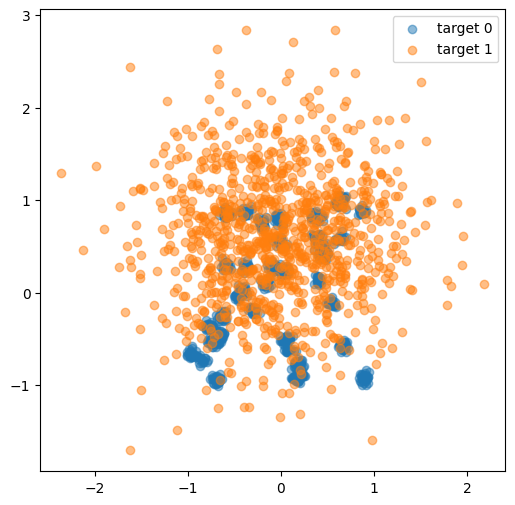

In [2]:
dim = 2
device = "cuda"
target_0 = GMM(n_mixes=40, dim=dim, loc_scaling=1.0, log_var_scaling=-3.5, device=device)
target_1 = GMM(n_mixes=1, dim=dim, loc_scaling=1.0, log_var_scaling=0., device=device)

samples_0 = target_0.sample((1000,))
samples_1 = target_1.sample((1000,))

plt.figure(figsize=(6, 6))
plt.scatter(samples_0.cpu()[:, 0], samples_0.cpu()[:, 1], alpha=0.5, label="target 0")
plt.scatter(samples_1.cpu()[:, 0], samples_1.cpu()[:, 1], alpha=0.5, label="target 1")
plt.legend()
plt.show()

In [3]:
denoiser_net = ImprovedFourierNet(
    dim=dim, 
    dim_out=dim, 
    num_layers=4, 
    channels=64,
    last_bias_init=init_bias_uniform_zeros, 
    last_weight_init=kaiming_uniform_zeros_
).to(device)
drift_net = ImprovedFourierNet(
    dim=dim, 
    dim_out=dim, 
    num_layers=4, 
    channels=64,
    last_bias_init=init_bias_uniform_zeros, 
    last_weight_init=kaiming_uniform_zeros_
).to(device)











In [4]:
si = StochasticInterpolant(
    drift_net=drift_net,
    denoiser_net=denoiser_net,
)

In [5]:
def display(t):
    xt = si.sample(t, samples_0, samples_1).cpu()
    plt.figure(figsize=(4, 4))
    plt.scatter(xt[:, 0], xt[:, 1], alpha=0.5)
    plt.title(f't={t}')
    plt.tight_layout()
    plt.show()

interact(display, t=(0.0, 1.0, 0.001))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.001), Output()), _dom_classes=('…

<function __main__.display(t)>

In [6]:
drift_fn = lambda t, x: si.optimal_drift(t, x, samples_0, samples_1)
n_steps=1000
simulated_x1, forward_traj = si.forward_ode(drift_fn, samples_0, start=1e-3, end=1.-1e-3, n_steps=n_steps)
simulated_x0, backward_traj = si.backward_ode(drift_fn, samples_1, start=1e-3, end=1.-1e-3, n_steps=n_steps)

Simulating: 100%|██████████| 999/999 [00:00<00:00, 2635.33it/s]


In [7]:
def display_traj(i):
    plt.subplots(1, 2, figsize=(8, 4))
    plt.subplot(1, 2, 1)
    xt = forward_traj[i]
    plt.scatter(xt[:, 0], xt[:, 1], alpha=0.5)
    plt.title(f'forward step={i}')
    plt.subplot(1, 2, 2)
    xt = backward_traj[i]
    plt.scatter(xt[:, 0], xt[:, 1], alpha=0.5)
    plt.title(f'backward step={i}')
    plt.tight_layout()
    plt.show()

interact(display_traj, i=(0, n_steps - 1, 1))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

<function __main__.display_traj(i)>

In [8]:
drift_fn = lambda t, x: si.optimal_drift(t, x, samples_0, samples_1)
denoiser_fn = lambda t, x: si.optimal_denoiser(t, x, samples_0, samples_1)
score_fn = si.denoiser_to_score_wrapper(denoiser_fn)
diffusion_fn = lambda t: 0.1
n_steps=1000
simulated_x1, forward_traj = si.forward_sde(drift_fn, score_fn, diffusion_fn, samples_0, start=1e-3, end=1.-1e-3, n_steps=n_steps)
simulated_x0, backward_traj = si.backward_sde(drift_fn, score_fn, diffusion_fn, samples_1, start=1e-3, end=1.-1e-3, n_steps=n_steps)

Simulating: 100%|██████████| 999/999 [00:02<00:00, 392.99it/s]


In [9]:
def display_traj(i):
    plt.subplots(1, 2, figsize=(8, 4))
    plt.subplot(1, 2, 1)
    xt = forward_traj[i]
    plt.scatter(xt[:, 0], xt[:, 1], alpha=0.5)
    plt.title(f'forward step={i}')
    plt.subplot(1, 2, 2)
    xt = backward_traj[i]
    plt.scatter(xt[:, 0], xt[:, 1], alpha=0.5)
    plt.title(f'backward step={i}')
    plt.tight_layout()
    plt.show()

interact(display_traj, i=(0, n_steps - 1, 1))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

<function __main__.display_traj(i)>